<a href="https://colab.research.google.com/github/roy-sub/Time-Series-Air-Quality-Index-Prediction-and-Analysis-using-Multiple-Deep-Learning-Models/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import r2_score
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

In [4]:
# 321300
df = pd.read_csv('air_quality_data_preprocessed')
df.shape

(31800, 33)

In [5]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,16,2013,3,1,15,8.0,15.0,7.0,14.0,400.0,...,77.0,7.395833,6.500000,12.890625,22.265625,3141.176471,77.0,6,3141.0,Severe
1,17,2013,3,1,16,9.0,19.0,9.0,13.0,400.0,...,77.0,7.843137,7.235294,12.794118,21.911765,2552.941176,77.0,6,2553.0,Severe
2,18,2013,3,1,17,10.0,23.0,11.0,15.0,400.0,...,77.0,8.333333,8.111111,12.847222,21.736111,2552.941176,77.0,6,2553.0,Severe
3,19,2013,3,1,18,11.0,20.0,8.0,20.0,500.0,...,77.0,8.859649,8.736842,12.697368,21.907895,3141.176471,77.0,6,3141.0,Severe
4,20,2013,3,1,19,8.0,14.0,12.0,30.0,500.0,...,77.0,9.083333,9.000000,12.812500,22.687500,3141.176471,77.0,6,3141.0,Severe


In [10]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your full dataset (e.g., a list or NumPy array)
train, test = train_test_split(df, test_size=0.2, random_state=42)


In [12]:
print(train[:10])  # or train.head() if it's a DataFrame


[[19706 2015 5 31 1 45.0 86.0 9.0 88.0 1200.0 26.0 20.8 1000.4 14.0 0.0
  'E' 1.5 'Aotizhongxin' 101.66666666666669 59.66666666666666
  7.041666666666667 48.25 1300.0 207.0 99.44444444444444
  101.11111111111111 8.802083333333334 60.3125 7847.058823529412 297.5 6
  7847.0 'Severe']
 [8915 2014 3 7 10 57.0 40.0 41.0 48.0 1100.0 24.0 6.1 1024.9 -20.3 0.0
  'NE' 3.4 'Aotizhongxin' 65.83333333333333 42.41666666666666
  23.291666666666668 47.833333333333336 1700.0 24.0 70.69444444444444
  65.83333333333333 29.114583333333336 59.79166666666667 10200.0 24.0 6
  10200.0 'Severe']
 [28224 2016 5 19 23 82.0 82.0 29.0 26.0 1300.0 196.0 23.5 1011.0 7.1 0.0
  'SSW' 2.2 'Aotizhongxin' 89.83333333333333 77.625 13.916666666666666
  27.70833333333333 1300.0 255.0 158.75 89.83333333333333
  17.395833333333332 34.635416666666664 7847.058823529412
  308.7198515769944 6 7847.0 'Severe']
 [16894 2015 2 2 21 134.0 157.0 73.0 83.0 1800.0 35.0 1.0 1027.0 -5.9 0.0
  'SW' 3.3 'Aotizhongxin' 159.875 136.333333333

In [ ]:
# Check the structure of 'train' and flatten if necessary
if isinstance(train, pd.DataFrame):
    if train.shape[1] == 1:  # If it's a DataFrame with one column, extract that column
        train = train.iloc[:, 0]
elif isinstance(train, np.ndarray):
    if train.ndim > 1:  # If it's a 2D array, flatten it
        train = train.flatten()
elif isinstance(train, list):
    train = np.array(train)  # Convert list to NumPy array

# Convert to numeric and handle NaNs manually (for NumPy arrays)
train = pd.to_numeric(train, errors='coerce')

# Remove NaN values using NumPy
train = train[~np.isnan(train)]

# Reshape and normalize
train = np.asarray(train).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train)

# Print first 5 normalized values
for i in range(min(5, len(train_norm))):
    print(train_norm[i])

[0.33426234]
[0.03471595]
[0.00068237]
[0.0011226]
[0.00061464]


In [18]:
train_norm = train_norm[train_norm!=0]

In [21]:
# Convert 'test' to a numpy array
test = np.asarray(test)

# If 'test' is multidimensional (e.g., 2D), flatten it
test = test.flatten()  # Flatten the array to make it 1D

# Convert to numeric, replace non-numeric values with NaN
test = pd.to_numeric(test, errors='coerce')

# Remove NaN values
test = test[~np.isnan(test)]

# Reshape the data for the scaler
test_norm = np.reshape(test, (-1, 1))

# Scaling all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)

# Printing first 5 normalized values
for i in range(min(5, len(test_norm))):
    print(test_norm[i])

[0.4969547]
[0.03471654]
[0.00069931]
[0.00064851]
[0.00075011]


In [22]:
test_norm = test_norm[test_norm != 0]

In [23]:
print(train_norm.shape)
print(test_norm.shape)

(763199,)
(190799,)


In [36]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [44]:
# Define the number of steps for input and output
n_steps_in = 3  # Input time steps (look-back)
n_steps_out = 5  # Output time steps (future prediction)

# Split the data into sequences
X_split_train, y_split_train = split_sequence(train_norm, n_steps_in, n_steps_out)
X_split_test, y_split_test = split_sequence(test_norm, n_steps_in, n_steps_out)

# Reshape the input data for LSTM (samples, timesteps, features)
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))


In [38]:
print(X_split_train.shape[0])
print(X_split_train.shape[1])
print(X_split_train.shape)

763192
3
(763192, 3, 1)


In [39]:
print(X_split_train[0])

[[0.33426234]
 [0.03471595]
 [0.00068237]]


In [28]:
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train[i])

[[0.33426234]
 [0.03471595]
 [0.00068237]]
[[0.03471595]
 [0.00068237]
 [0.0011226 ]]
[[0.00068237]
 [0.0011226 ]
 [0.00061464]]
[[0.0011226 ]
 [0.00061464]
 [0.00135965]]
[[0.00061464]
 [0.00135965]
 [0.00205387]]


In [29]:
print(X_split_train.shape)

(763196, 3, 1)


In [30]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])

[0.4969547  0.03471654 0.00069931] 0.0006485117248549314
[0.03471654 0.00069931 0.00064851] 0.0007501062509418659
[0.00069931 0.00064851 0.00075011] 0.0030190506668834015
[0.00064851 0.00075011 0.00301905] 0.0030190506668834015
[0.00075011 0.00301905 0.00301905] 0.0006654441458694206


In [31]:
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))
for i in range(5):
    print(X_split_test[i])

[[0.4969547 ]
 [0.03471654]
 [0.00069931]]
[[0.03471654]
 [0.00069931]
 [0.00064851]]
[[0.00069931]
 [0.00064851]
 [0.00075011]]
[[0.00064851]
 [0.00075011]
 [0.00301905]]
[[0.00075011]
 [0.00301905]
 [0.00301905]]


In [32]:
print(X_split_test.shape)

(190796, 3, 1)


In [ ]:
# design network
# model = Sequential()
# model.add(LSTM(128, activation='relu', return_sequences = True, input_shape=(X_split_test.shape[1], X_split_test.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(100, activation='relu', return_sequences = True, name = "LSTM_2"))
# model.add(Dropout(0.2))
# model.add(LSTM(50, activation='relu', return_sequences = True, name = "LSTM_3"))
# model.add(Dropout(0.2))
# model.add(LSTM(32, activation='relu',name = "LSTM_3"))
# model.add(Dropout(0.2))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [45]:
# design network : LSTM for multi-step output
model = Sequential()
model.add(LSTM(128, input_shape=(n_steps, n_features)))
model.add(Dense(50, activation='tanh'))
model.add(Dense(n_steps_out))  # Output 5 future steps
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()


e:\Projects\Time-Series-Air-Quality-Index-Prediction-and-Analysis-using-Multiple-Deep-Learning-Models\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,265 (286.19 KB)

 Trainable params: 73,265 (286.19 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)

Epoch 1/10
23850/23850 ━━━━━━━━━━━━━━━━━━━━ 98s 4ms/step - accuracy: 0.2310 - loss: 0.0254 - val_accuracy: 0.2177 - val_loss: 0.0234
Epoch 2/10
23850/23850 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.2342 - loss: 0.0231 - val_accuracy: 0.3092 - val_loss: 0.0224
Epoch 3/10
23850/23850 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - accuracy: 0.2845 - loss: 0.0224 - val_accuracy: 0.3550 - val_loss: 0.0221
Epoch 4/10
23850/23850 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - accuracy: 0.3722 - loss: 0.0221 - val_accuracy: 0.3882 - val_loss: 0.0213
Epoch 5/10
23850/23850 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - accuracy: 0.4044 - loss: 0.0209 - val_accuracy: 0.3925 - val_loss: 0.0200
Epoch 6/10
23850/23850 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - accuracy: 0.4604 - loss: 0.0200 - val_accuracy: 0.4749 - val_loss: 0.0198
Epoch 7/10
23850/23850 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - accuracy: 0.4933 - loss: 0.0195 - val_accuracy: 0.5044 - val_loss: 0.0192
Epoch 8/10
23850/23850 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy:

In [47]:
yhat = model.predict(X_split_test)
for i in range(5):
    print(yhat[i])

5963/5963 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
[0.00039617 0.00023565 0.00202287 0.00152785 0.00106506]
[ 0.00030756  0.00092262  0.00248014 -0.00082792  0.00186616]
[0.00197949 0.00056328 0.00122103 0.00656549 0.00325648]
[0.00195412 0.00036845 0.00251075 0.00401732 0.00290872]
[0.00098825 0.00109471 0.0276681  0.00295835 0.00279074]


In [48]:
mse = mean_squared_error(y_split_test, yhat)
print('MSE: %.5f' % mse)

MSE: 0.00421


In [49]:
model.save('lstm_model.keras')


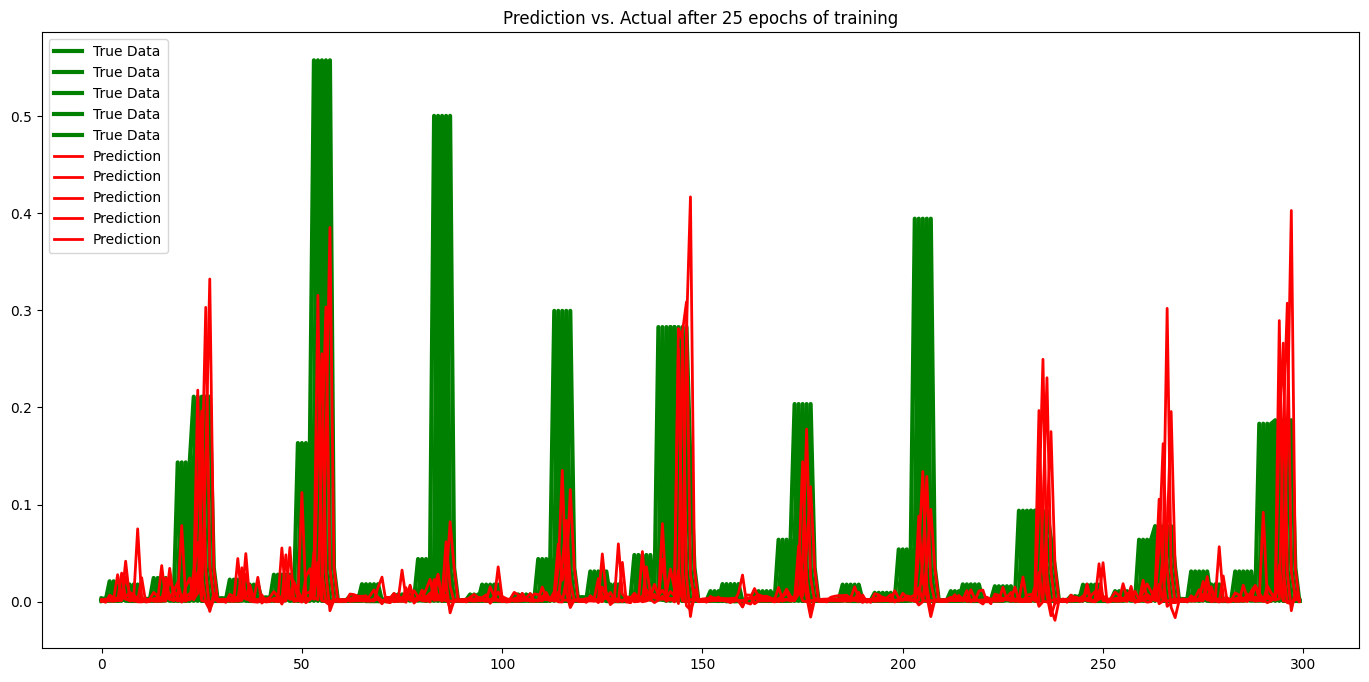

Root Mean Squared Error: 0.0649
R2 score : 0.39


In [50]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 25 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

plot_predicted(yhat[:300,], y_split_test[:300,])
rmse = sqrt(mean_squared_error(y_split_test, yhat))
print('Root Mean Squared Error: {:.4f}'.format(rmse))
print("R2 score : %.2f" % r2_score(y_split_test, yhat))

In [51]:
_, train_acc = model.evaluate(X_split_train, y_split_train, verbose=0)
_, test_acc = model.evaluate(X_split_test, y_split_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.55379, Test: 0.55616


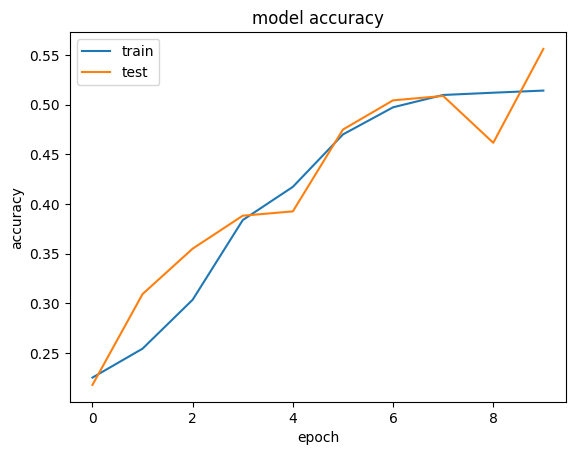

In [52]:
# Resolve the issue

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

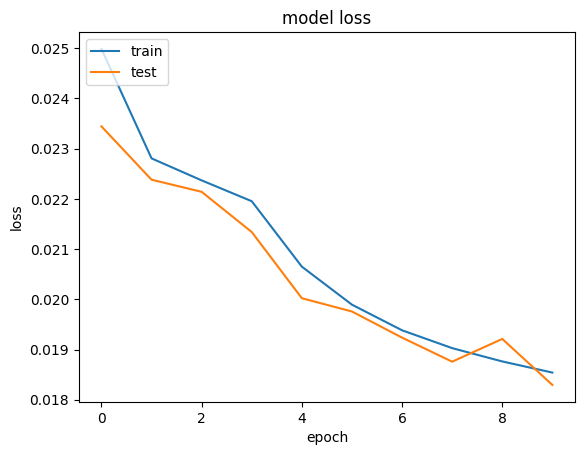

In [53]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()